Tente aprimorar os desempenhos dos modelos do notebook. Há margem para melhorias nos resultados e nas eficiências computacionais. Algumas sugestões:

* Varie as arquiteturas das redes e os demais hiperparâmetros (números de filtros, taxas de dropout, etc.).  
* Crie ensembles nos casos em que usamos apenas um modelo (MNIST e Fashion MNIST). Teste várias estruturas para os ensembles (número de modelos, arquitetura de cada modelo individual, maneira de agregar os resultados, etc.).  
* Use a estratégia de aumento de dados, que consiste em alimentar aos modelos não apenas as imagens originais e sim um conjunto potencialmente muito maior, composto por imagens com pequenas variações das originais. Você pode implementar o aumento de dados facilmente fornecendo hiperparâmetros descrevendo as variações das imagens à classe ImageDataGenerator (cheque a referência para mais detalhes).  
* Use modelos pré-treinados para introduzir parâmetros não-treináveis nas primeiras camadas (transferência de aprendizado).  
* etc, etc.  
* 
Durante seus testes, é instrutivo verificar também quais modificações não ajudam ou mesmo pioram o desempenho.  

Na Internet, em particular no Kaggle e principalmente para o MNIST, você pode encontrar implementações das ideias citadas acima ou de outras ideias. Há material de sobra para estudo e exploração. Boa jornada!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import shuffle
sns.set()

from random import choices
from random import seed

# Fashion MNIST

## Importando Dataset

In [2]:
fashion_PATH = '/kaggle/input/fashionmnist/'

fashion_train = pd.read_csv(fashion_PATH+'fashion-mnist_train.csv')
fashion_test = pd.read_csv(fashion_PATH+'fashion-mnist_test.csv')

In [3]:
X_train, y_train = fashion_train.iloc[:,1:].values/255, fashion_train.iloc[:,0].values
X_test, y_test = fashion_test.iloc[:,1:].values/255, fashion_test.iloc[:,0].values

X_train = X_train.reshape(-1,28, 28, 1)
X_test = X_test.reshape(-1,28, 28, 1)

In [4]:
label = {
0:'T-shirt/top',
1:'Trouser',
2:'Pullover',
3:'Dress',
4:'Coat',
5:'Sandal',
6:'Shirt',
7:'Sneaker',
8:'Bag',
9:'Ankle boot'
}

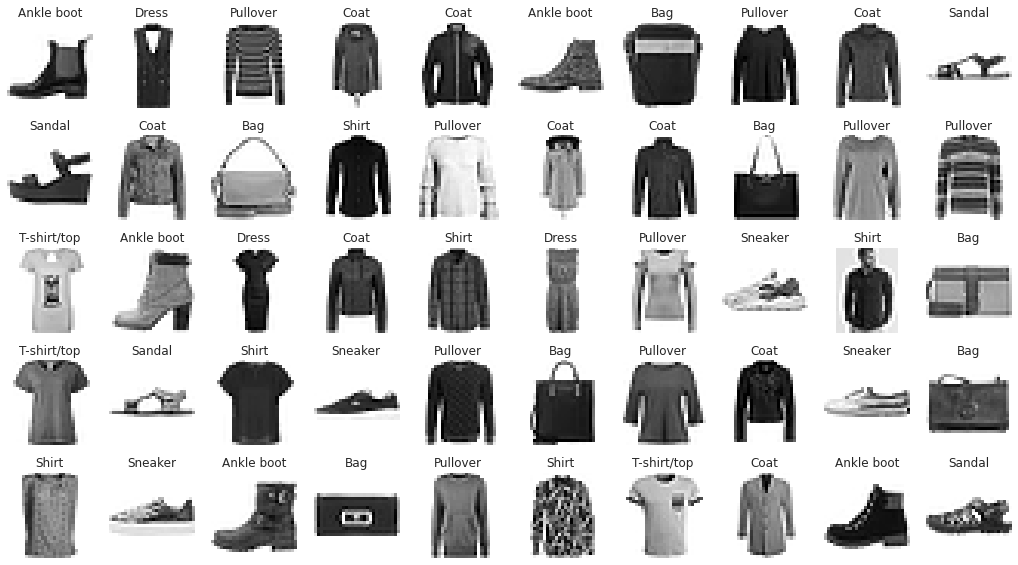

In [5]:
N_images = 50

# localização dos exemplos na matriz de dados 
rows = choices(range(0, 60000), k=N_images)

# selecionando os dígitos, já no formato de matriz
digitos = [X_train[i].reshape(28,28) for i in rows]
label_value = y_train[rows]

# criando figura do matplotlib
fig, ax = plt.subplots(5, int(len(rows)/5),figsize=(18,10))

# plotando!
for i in range(len(rows)):
    j = int(i/10)
    k = i - j*10
    ax[j, k].imshow(digitos[i], cmap = plt.cm.binary, interpolation="nearest")
    ax[j, k].set_title(label[label_value[i]])
    ax[j, k].axis('off')

[]

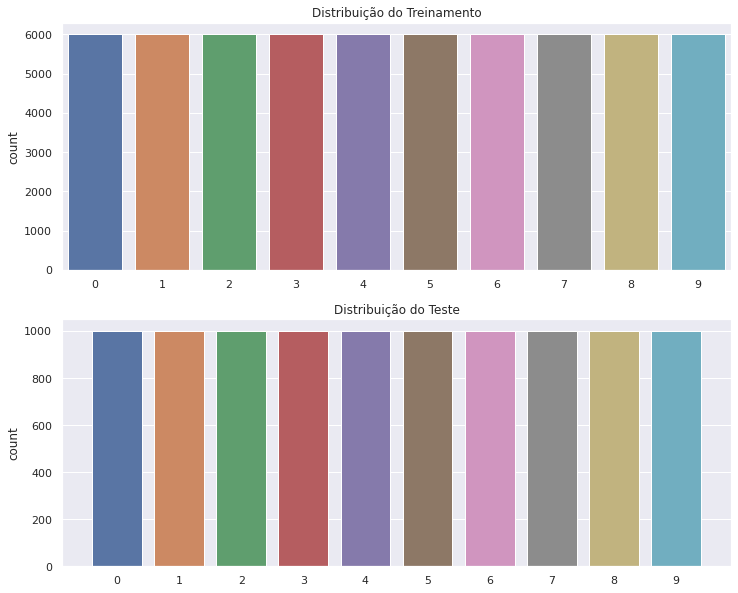

In [6]:
fig, ax = plt.subplots(2,figsize=(12,10))

sns.countplot(y_train, ax=ax[0])
ax[0].set_title('Distribuição do Treinamento')
sns.countplot(y_test, ax=ax[1])
ax[1].set_title('Distribuição do Teste')

plt.plot()

A distribuição de teste e treinamento tem uma proporção aceitável.

## Funções auxiliares

In [7]:
def plot_erros(model, X, target, cols=10, rows=5):

    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    
    predicao = pd.DataFrame(data={'predicao':y_pred, 'target':target})
    predicao_erros = predicao[predicao.predicao != predicao.target]
    
    digitos = predicao_erros.index

    fig, ax = plt.subplots(rows, cols,figsize=(4*rows,1.2*cols))

    count = 0
    for row in range(0, rows):
        for col in range(0, cols):
            if count<len(digitos):
                ax[row, col].imshow(X[digitos[count],:,:,0], cmap = plt.cm.binary, interpolation="nearest")
                ax[row, col].set_title(f'{target[digitos[count]]} confused {y_pred[digitos[count]]}')
            ax[row, col].axis('off')
            count +=1

## Keras CNN

In [8]:
class MultiCNN():
    def __init__(self, model_generator, num_models=1):
        self.models = []
        self.create_models(model_generator, num_models)
        
    def create_models(self, model_generator, num_models=1):
        for i in range(0,num_models):
            m = keras.models.Sequential(model_generator())

            m.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            self.models.append(m)
            
    def fit(self, train_inputs, train_targets, early_stop=True, verbose=2, batch_size=200, epochs=100):
        callback = []
        
        if early_stop:
            callback.append(keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5))
        
        for m in self.models:
            X_train2, X_val2, y_train2, y_val2 = train_test_split(train_inputs, train_targets, test_size = 0.2)
            m.fit(X_train2, y_train2, 
                  batch_size= batch_size, 
                  epochs = epochs,
                  callbacks=callback,
                  validation_data = (X_val2, y_val2),
                  verbose=verbose
                 )
            
    def fit_generator(self, generator, train_inputs, train_targets, early_stop=True, verbose=2, batch_size=32, epochs=100):
        callback = []
        
        if early_stop:
            callback.append(keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5))
        
        for m in self.models:
            X_train2, X_val2, y_train2, y_val2 = train_test_split(train_inputs, train_targets, test_size = 0.2)
            
            m.fit_generator(generator.flow(X_train2,y_train2, batch_size=batch_size),
                            epochs = epochs,
                            callbacks=callback,
                            validation_data = (X_val2, y_val2),
                            verbose=verbose
                            )
            
    def predict(self, test_inputs):
        prediction = [model.predict(test_inputs) for model in self.models]
        return sum(prediction)/len(prediction)
    
    def acuracia(self, test_input, test_target):
        prediction = self.predict(test_input)
        prediction = np.argmax(prediction, axis=1)
        return accuracy_score(prediction, test_target)
    
    def confusion_matrix(self, test_input, test_target):
        
        y_pred = self.predict(test_input)

        y_pred = np.argmax(y_pred, axis=1)

        confusao = confusion_matrix(y_pred, test_target)

        fig, ax = plt.subplots(1, figsize=(10,10))
        sns.heatmap(pd.DataFrame(confusao), ax=ax, cbar=False, annot=True)
        ax.set_title('Matriz de confusão', size=20)
        ax.set_yticklabels(ax.get_xticklabels(), rotation=0, size=15)
        ax.set_xticklabels(ax.get_yticklabels(), rotation=0, size=15)
        plt.show()

In [9]:
def make_CNN():
    return  [

            keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
            keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),

            keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
            keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),

            keras.layers.Flatten(),
            keras.layers.Dense(units=64, activation="relu"),

            keras.layers.Dropout(0.2),

            keras.layers.Dense(units=10, activation="softmax")

            ]
    


multiCNN = MultiCNN(make_CNN, num_models=5)

multiCNN.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN.acuracia(X_test, y_test)

0.9287

## Adicionando uma camada ao final 

In [10]:
def make_CNN():
    return  [

                keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),

                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),

                keras.layers.Flatten(),
                keras.layers.Dense(units=64, activation="relu"),
                keras.layers.Dense(units=64, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

            ]

multiCNN = MultiCNN(make_CNN, num_models=5)

multiCNN.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN.acuracia(X_test, y_test)

0.9288

Apresentou uma pequena melhora

## Alteração da camada de Pooling para média

In [11]:
def make_CNN():
    return  [

                keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),

                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),

                keras.layers.Flatten(),
                keras.layers.Dense(units=64, activation="relu"),
                keras.layers.Dense(units=64, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

            ]

multiCNN = MultiCNN(make_CNN, num_models=5)

multiCNN.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN.acuracia(X_test, y_test)

0.9236

Apresentou pequena melhora

## Normalização por lote

In [12]:
def make_CNN():
    return  [

                keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Flatten(),
                keras.layers.Dense(units=64, activation="relu"),
                keras.layers.Dense(units=64, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

            ]

multiCNN = MultiCNN(make_CNN, num_models=5)

multiCNN.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN.acuracia(X_test, y_test)

0.9273

Houve pequena melhora

## Adição de mais camadas de dropout

In [13]:
def make_CNN():
    return  [

                keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
        
                keras.layers.Dropout(0.2),
                keras.layers.BatchNormalization(),

                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
        
                keras.layers.Dropout(0.2),
                keras.layers.BatchNormalization(),

                keras.layers.Flatten(),
                keras.layers.Dense(units=64, activation="relu"),
        
                keras.layers.Dropout(0.2),
        
                keras.layers.Dense(units=64, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

            ]


multiCNN = MultiCNN(make_CNN, num_models=5)

multiCNN.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN.acuracia(X_test, y_test)

0.9265

Não houve alteração significativa

## Aumento do número de neurônios nas últimas camada

In [14]:
def make_CNN():
    return  [

                keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Flatten(),
                keras.layers.Dense(units=100, activation="relu"),
                keras.layers.Dense(units=100, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

            ]

multiCNN = MultiCNN(make_CNN, num_models=5)

multiCNN.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN.acuracia(X_test, y_test)

0.9322

Não houve alteração significativa

## Aumento do tamanho do Kernel

In [15]:
def make_CNN():
    return  [

                keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Flatten(),
                keras.layers.Dense(units=64, activation="relu"),
                keras.layers.Dense(units=64, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

            ]

multiCNN = MultiCNN(make_CNN, num_models=5)

multiCNN.fit(X_train, y_train, verbose = 0, early_stop=True)

multiCNN.acuracia(X_test, y_test)

0.9335

Não afetou de forma significativa

## Adição de dados

In [16]:
datagen = keras.preprocessing.image.ImageDataGenerator(
                                                        featurewise_center=False,
                                                        samplewise_center=False,
                                                        featurewise_std_normalization=False,
                                                        samplewise_std_normalization=False,
                                                        zca_whitening=False,
                                                        zca_epsilon=1e-06,
                                                        rotation_range=0, # não será adicionado rotação pois as imagens estão sempre alinhadas
                                                        width_shift_range=0.2,
                                                        height_shift_range=0.2,
                                                        brightness_range=None,
                                                        shear_range=0.2,
                                                        zoom_range=0.2,
                                                        channel_shift_range=0.0,
                                                        fill_mode="nearest",
                                                        cval=0.0,
                                                        horizontal_flip=False,
                                                        vertical_flip=False,
                                                        rescale=None,
                                                        preprocessing_function=None,
                                                        data_format=None,
                                                        validation_split=0.0,
                                                        dtype=None,
                                                    )

datagen.fit(X_train)

In [17]:
def make_CNN():
    return  [

                keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(28, 28, 1)),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
                keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
                keras.layers.BatchNormalization(),

                keras.layers.Flatten(),
                keras.layers.Dense(units=64, activation="relu"),
                keras.layers.Dense(units=64, activation="relu"),

                keras.layers.Dropout(0.2),

                keras.layers.Dense(units=10, activation="softmax")

            ]


multiCNN = MultiCNN(make_CNN, num_models=5)

multiCNN.fit_generator(datagen, X_train, y_train, verbose = 0, early_stop=True)

multiCNN.acuracia(X_test, y_test)

0.9041

A adição de novas imagens geradas piorou o modelo. Como esperado pois cada classe não possui somente pequenas variações de rotação e centro 